In [1]:
from IPython.display import Image

import torchvision.transforms as T
import numpy as np
import torch.nn as nn
import torch as th
import matplotlib.pyplot as plt

from torchsummary import summary

from models.unet_original import *
from models.unet_resnet_inception import *

from train.unet_trainer import UnetTrainer
from train.utils import*

from visual.plots import *

#from datasets.utils.import_export import *
from datasets.semantic import *

import os

import tifffile as tif

## Helper functions to prepare the images

In [2]:
def convert_images(img, label):
    label_array = np.asarray(label, dtype=np.float32)
    label_array = np.where(label_array > 0, 1, 0)
    
    new_label_array = np.zeros((2, *label_array.shape))
    
    for i in range(2):
        if i == 0:
            new_label_array[i] = np.where(label_array == 0, 1, 0)
        else: 
            new_label_array[i] = np.where(label_array == 1, 1, 0)
    
    label_array = th.from_numpy(new_label_array)
    #label_array = th.unsqueeze(label_array, 0) 
    
    
    img = np.asarray(img, dtype=np.float32)
    
    
    img = th.from_numpy(img)
    img = th.unsqueeze(img, 0)

    return img, label_array


def assemble_dataset(path):
    
    ds = []

    images_path = os.path.join(path, 'images')
    labels_path = os.path.join(path, 'labels')
    
    image_list = listdir(images_path)
    label_list = listdir(labels_path)

    for img in image_list:
        for label in label_list:
            
            if os.path.basename(img) == os.path.basename(label):
                img_matched = tif.imread(os.path.join(images_path, img))
                label_matched = tif.imread(os.path.join(labels_path, label))
                
                img_matched, label_matched = convert_images(img_matched, label_matched)
                
                
                ds.append((img_matched, label_matched))
    
    return ds

## Split Dataset

In [3]:
cwd = os.getcwd()

ds_path = os.path.join(cwd, 'data')
ds = assemble_dataset(ds_path)

#ds_train, ds_test = th.utils.data.random_split(ds, [70, 15])

ds_test = ds[:10]
ds_train = ds[11:]

## Define the parameters and set up the network

In [4]:
classes = [0, 2]

params = {
    'out_classes': 2,
    'padding_mode': 'reflect',
    'batch_size': 1, #as high as possible
    'input_conv_kernel_size': 3,
    'window_size': 512,
    'input_dim': 512,
    'depth': 5, #play with this
    'start_layers': 8, #play with this
    'dim_multiplier': 8, #play with this
    'dropout_p': 0.0,
    'num_batches': 100,
    'normalized': True
}

dev = th.device("cuda") if th.cuda.is_available() else th.device("cpu")

#net = UNetResInc(params).to(dev)
net = UNet2(params).to(dev)
optim = th.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
#optim = th.optim.SGD(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()# reduction='none')

trainer = UnetTrainer(net, dev, criterion, optim, ds_train, ds_train)

## Train

i:  0


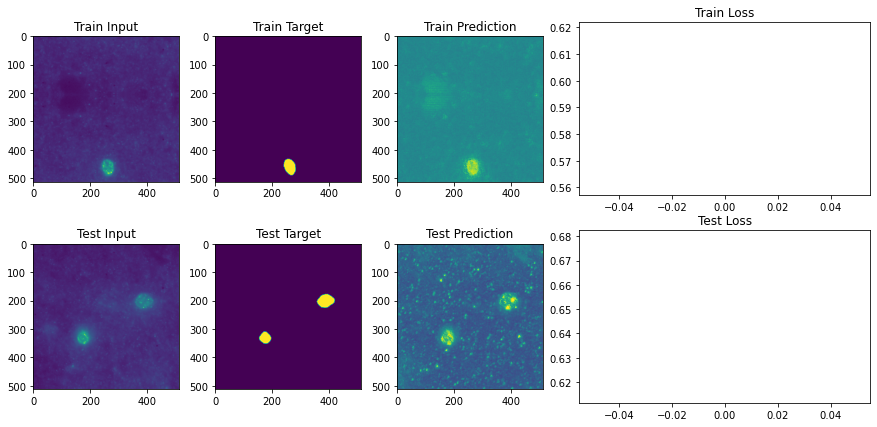

i:  1


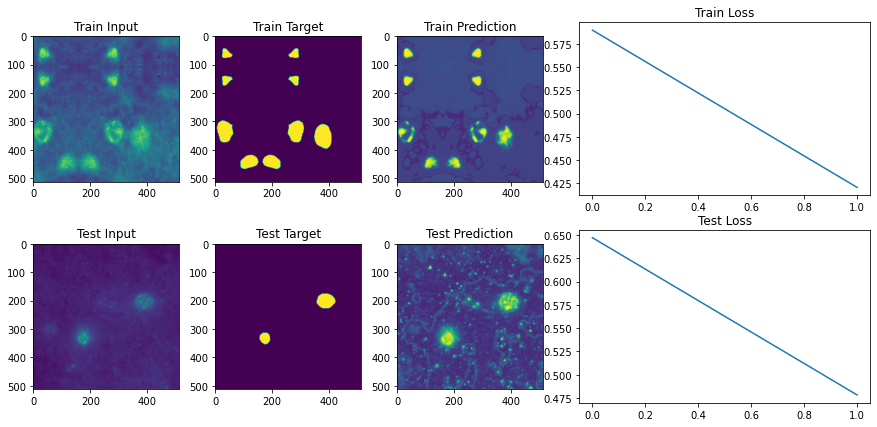

i:  2


In [ ]:
#ds_train_augmented = get_random_reflections(ds_train, 2000, params['batch_size'], (params['window_size'], params['window_size']), (params['input_dim'], params['input_dim']), normalized=True)

ds_train_augmented = get_random_reflections(ds_train, 100, params['batch_size'], (params['window_size'], params['window_size']), (params['input_dim'], params['input_dim']), normalized=True)

for i in range(2000):
    print('i: ', i)
    #ds_train_augmented = get_random_reflections(ds_train, params['num_batches'], params['batch_size'], (params['window_size'], params['window_size']), (params['input_dim'], params['input_dim']), normalized=True)
    trainloader = th.utils.data.DataLoader(ds_train_augmented, batch_size=params['batch_size'], shuffle=True, num_workers=0)
    
    #ds_test_augmented = get_random_reflections(ds_test, params['num_batches'] // 5, params['batch_size'], (params['window_size'], params['window_size']), (params['input_dim'], params['input_dim']), normalized=True)
    testloader = th.utils.data.DataLoader(ds_test, 1, shuffle=True, num_workers=0)
    
    img, tar, pre = trainer.train_epoch(trainloader)    
    img_t, tar_t, pre_t = trainer.test(testloader)
    
    if i % 1 == 0:
        # plt.imshow(img_t[0][0])
        # plt.savefig('charts/' + 'test_input_epochs_' + str(i) + '.jpg')
        # plt.show()
        # plt.imshow(tar_t[0][1])
        # plt.savefig('charts/' + 'test_target_epochs_' + str(i) + '.jpg')
        # plt.show()
        # plt.imshow(pre_t[0][1])
        # plt.savefig('charts/' + 'test_output_epochs_' + str(i) + '.jpg')
        # plt.show()
        
        plot_performance(img[0][0], img_t[0][0], tar[0][1], tar_t[0][1], pre[0][1], pre_t[0][1], trainer.train_losses, trainer.test_losses, figsize=(15, 7))

## 